# Packages

In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import anndata
import matplotlib.pyplot as plt
import harmonypy as hm
from modules.visualize import *
from modules.deg_analysis import *
import seaborn as sns
from collections import Counter
from MCML.modules import MCML, bMCML
from MCML import tools as tl
import anndata2ri
import logging
import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri, r
from scipy.sparse import csr_matrix
from scipy.sparse import issparse

/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-07-16 20:36:31.741344: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-16 20:36:32.273698: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
adata = sc.read(
    filename="data/fede_count_clustered.h5ad"
)

# Differential gene expression analysis

In [3]:
ctr_cell_types = [x for x in set(adata.obs.cluster_subclass_name.values) if x.startswith('Astro-NT')]
ctr_sample_tags = [x for x in set(adata.obs.Sample_Tag.values)]
ctr_sample_tags = ['WT-DMSO']

cnd_cell_types = [x for x in set(adata.obs.cluster_subclass_name.values) if x.startswith('Astro-NT')]
cnd_sample_tags = [x for x in set(adata.obs.Sample_Tag.values)]
cnd_sample_tags = ['3xTg-DMSO']

In [4]:
ctr_idx = adata[(adata.obs['Sample_Tag'].isin(ctr_sample_tags)) & (adata.obs['cluster_subclass_name'].isin(ctr_cell_types))].obs.index
cnd_idx = adata[(adata.obs['Sample_Tag'].isin(cnd_sample_tags)) & (adata.obs['cluster_subclass_name'].isin(cnd_cell_types))].obs.index
ctr_name = 'Astro-NT WT-DMSO'
cnd_name = 'Astro-NT 3xTg-DMSO'

In [5]:
adata.obs['group'] = ['control' if i in ctr_idx else 'condition' if i in cnd_idx else 'undefined' for i in adata.obs.index]

In [6]:
filtered_adata = adata[adata.obs['group'] != 'undefined']

In [10]:
results_df = DEG_analysis(filtered_adata,
                           save_path=f'figures/{ctr_name}_{cnd_name}_results_df.pkl')

In [ ]:
results_df = DEG_analysis_mast(filtered_adata,
                            save_path=f'figures/{ctr_name}_{cnd_name}_results_df.pkl')

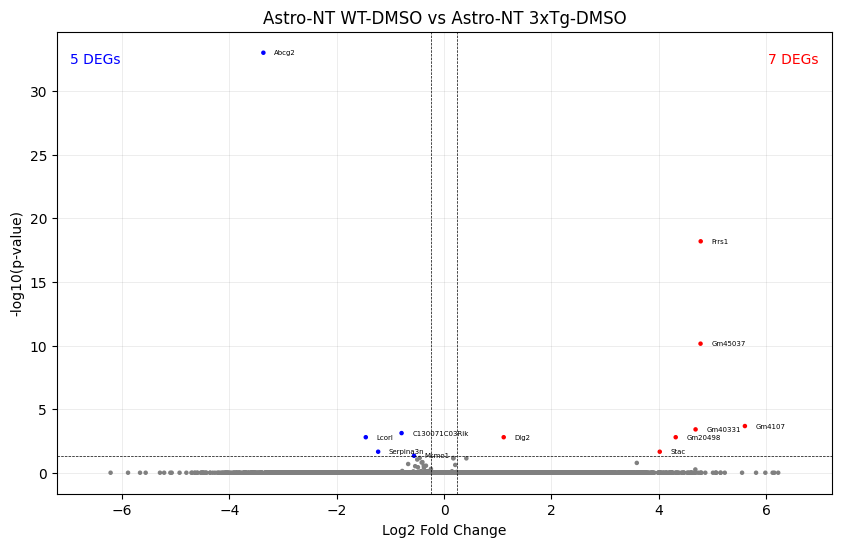

In [11]:
volcano_plot(results_df,
             min_fold_change=0.25,
             max_p_value=0.05,
             fig_title=f'{ctr_name} vs {cnd_name}',
             save_path=f'figures/{ctr_name}_{cnd_name}_volcano_plot.png')

# Compositional analysis

# Gene set enrichment and pathway analysis

In [12]:
UP_genes_name, DOWN_genes_name = get_DEGs(results_df,
                                          max_pval=0.05,
                                          min_fold_change=0.25)

In [13]:
UP_GO = go_enrichment_analysis(UP_genes_name, save_path=None)
DOWN_GO = go_enrichment_analysis(DOWN_genes_name, save_path=None)

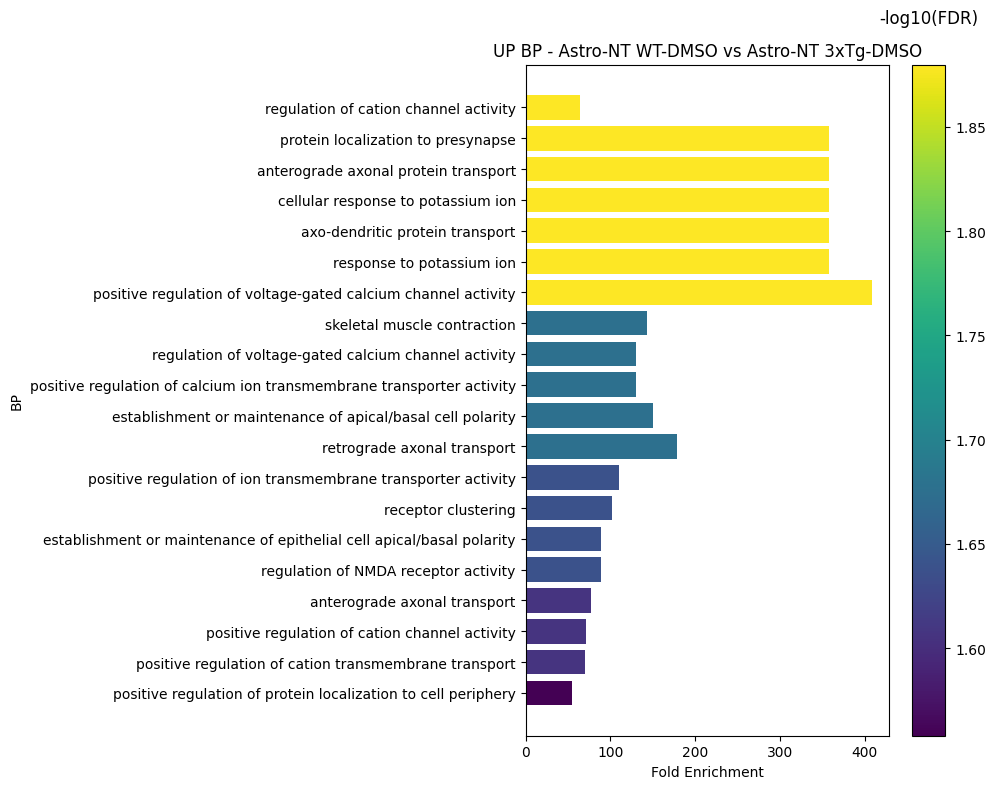

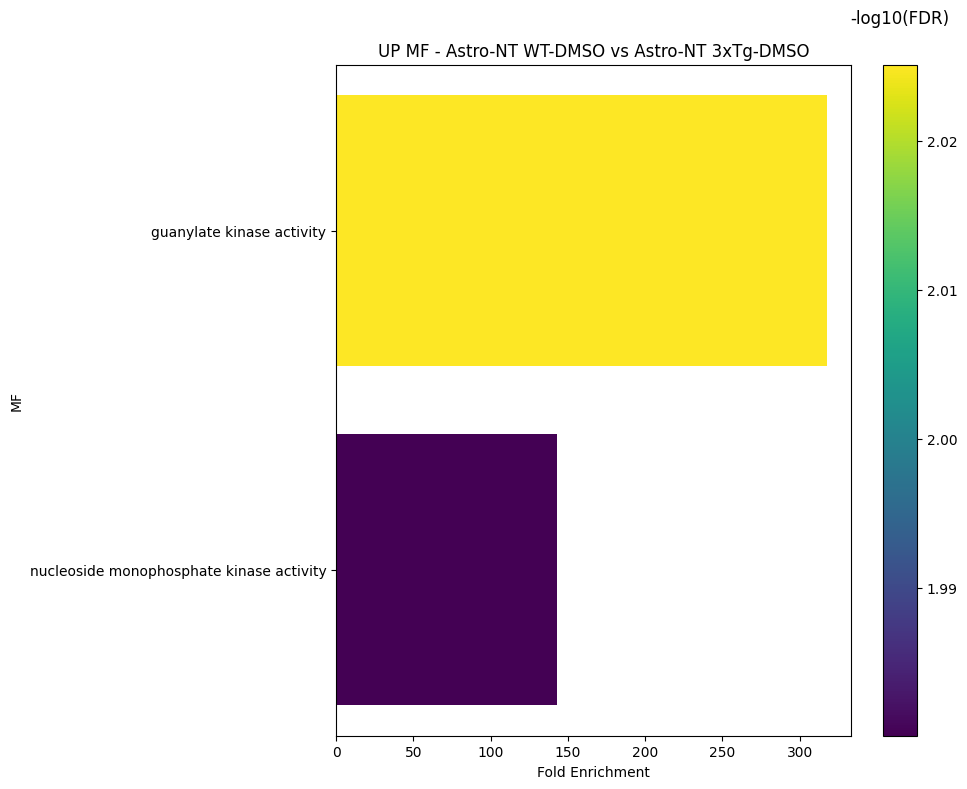

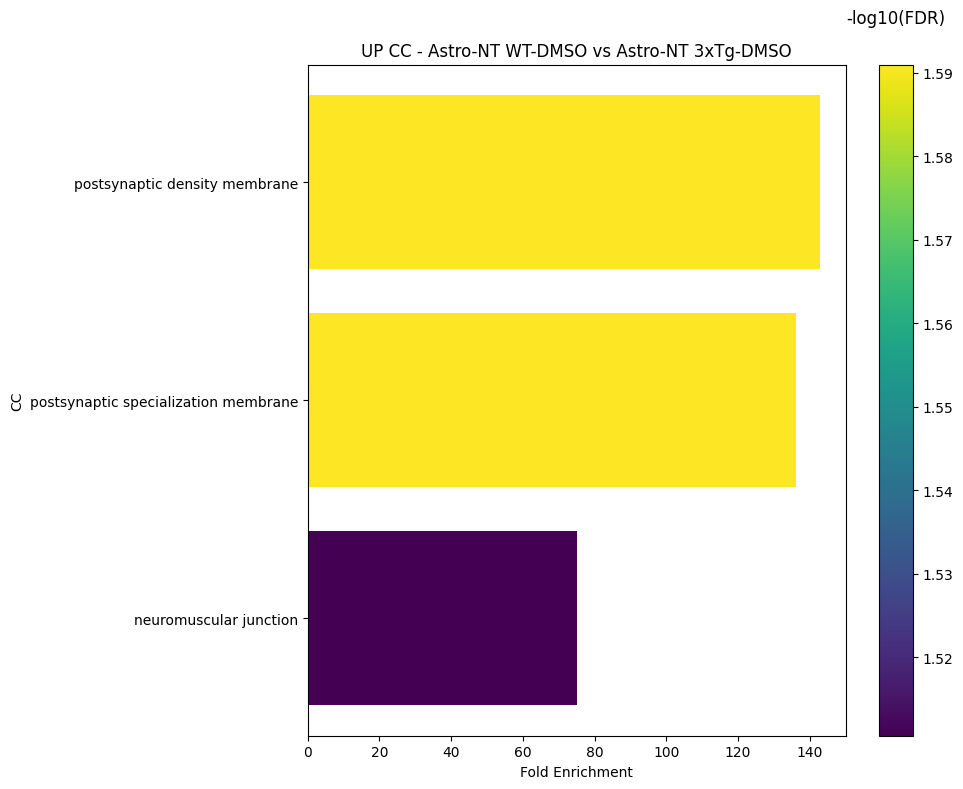

In [14]:
display_go_enrichment(UP_GO,
                      namespace='BP',
                      fig_title=f'UP BP - {ctr_name} vs {cnd_name}',
                      save_path=f'figures/{ctr_name}_{cnd_name}_display_GO_enrichment_UP_BP')

display_go_enrichment(UP_GO, 
                      namespace='MF',
                      fig_title=f'UP MF - {ctr_name} vs {cnd_name}',
                      save_path=f'figures/{ctr_name}_{cnd_name}_display_GO_enrichment_UP_MF')

display_go_enrichment(UP_GO, 
                      namespace='CC',
                      fig_title=f'UP CC - {ctr_name} vs {cnd_name}',
                      save_path=f'figures/{ctr_name}_{cnd_name}_display_GO_enrichment_UP_CC')

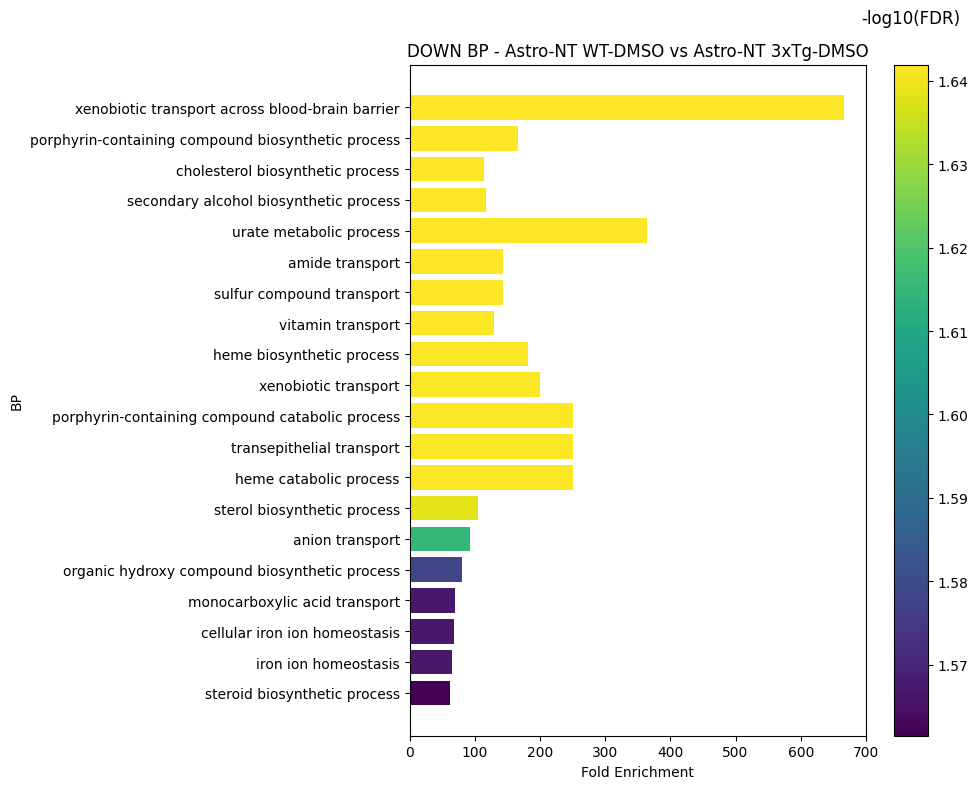

/home/client/projects/sc_alz/modules/deg_analysis.py:521: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


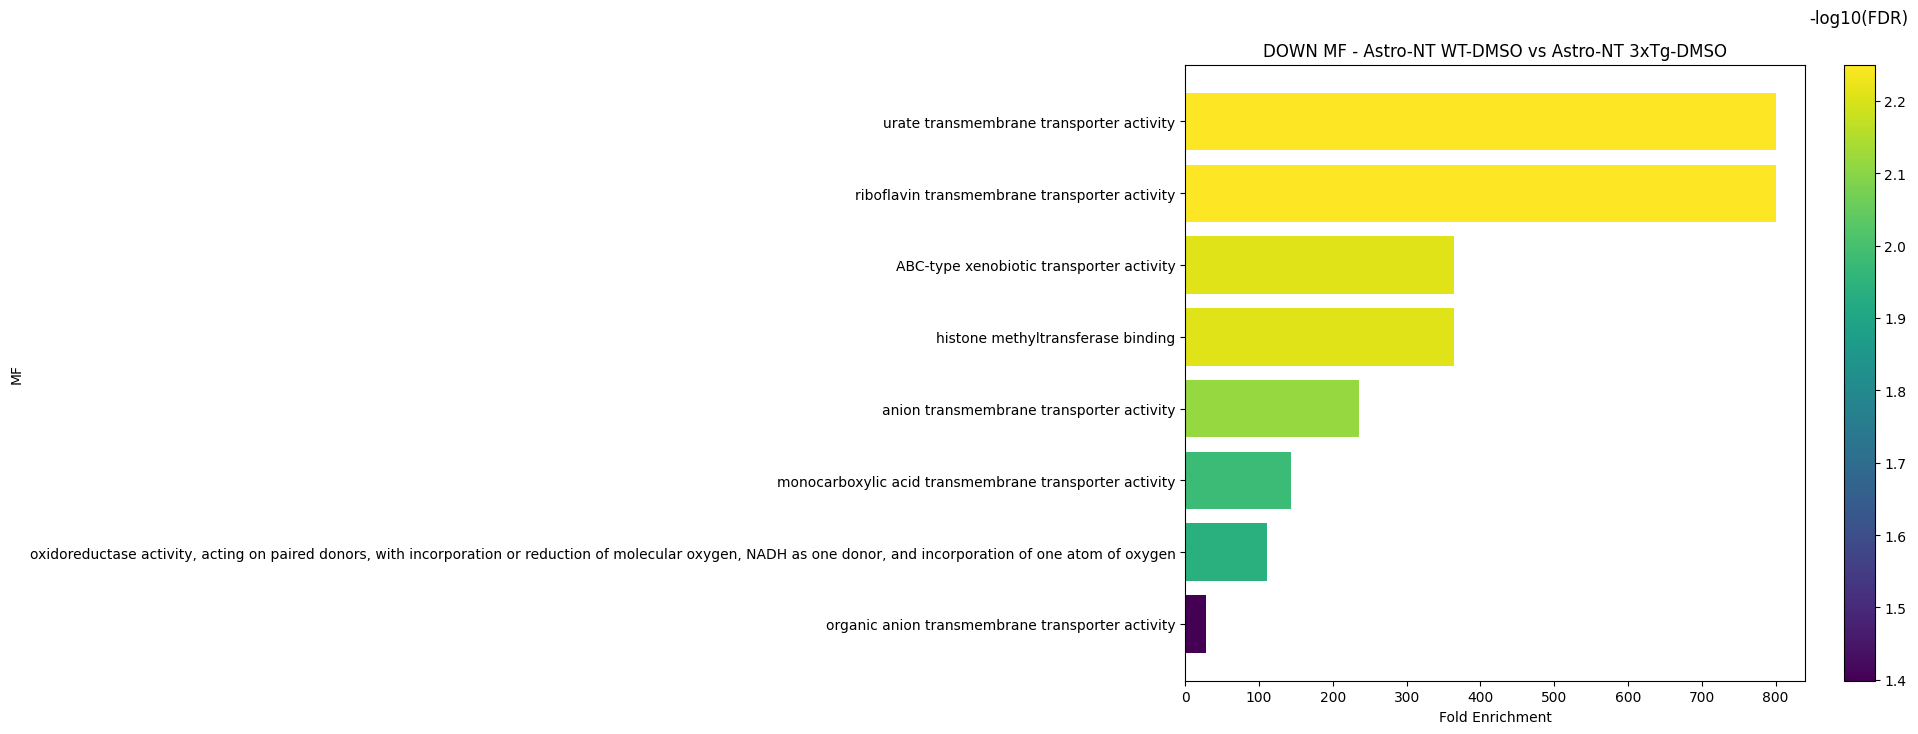

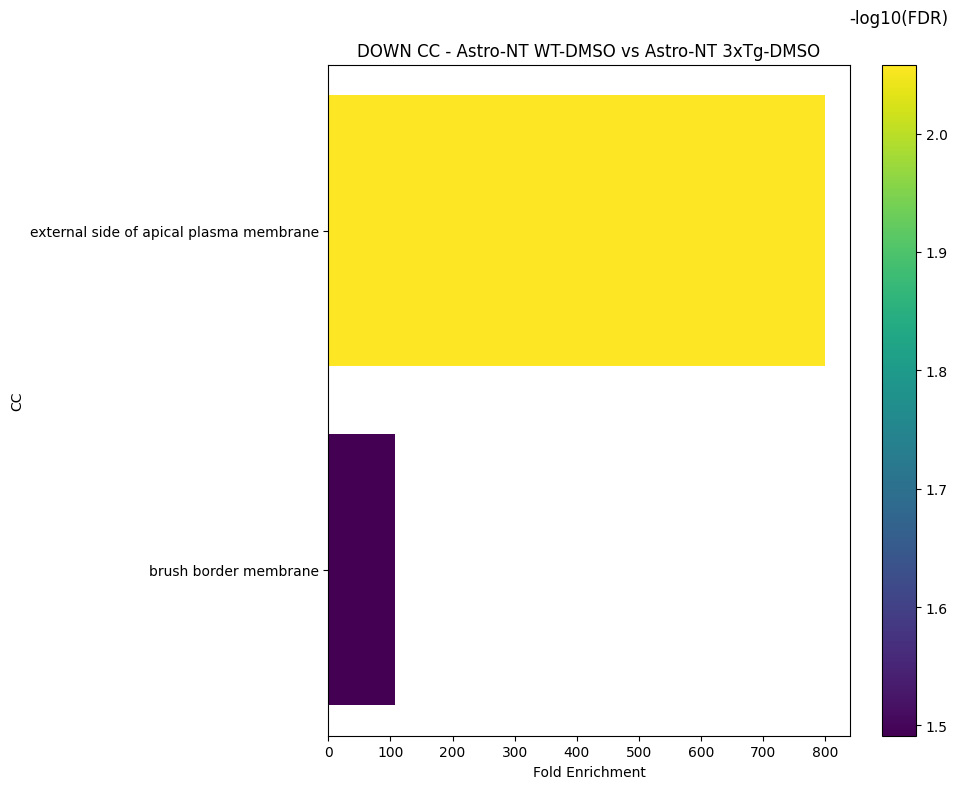

In [15]:
display_go_enrichment(DOWN_GO, 
                      namespace='BP',
                      fig_title=f'DOWN BP - {ctr_name} vs {cnd_name}',
                      save_path=f'figures/{ctr_name}_{cnd_name}_display_GO_enrichment_DOWN_BP')

display_go_enrichment(DOWN_GO, 
                      namespace='MF',
                      fig_title=f'DOWN MF - {ctr_name} vs {cnd_name}',
                      save_path=f'figures/{ctr_name}_{cnd_name}_display_GO_enrichment_DOWN_MF')

display_go_enrichment(DOWN_GO, 
                      namespace='CC',
                      fig_title=f'DOWN CC - {ctr_name} vs {cnd_name}',
                      save_path=f'figures/{ctr_name}_{cnd_name}_display_GO_enrichment_DOWN_CC')

In [16]:
UP_KEGG = kegg_enrichment_analysis(UP_genes_name, 
                                   save_path=None)

In [17]:
DOWN_KEGG = kegg_enrichment_analysis(DOWN_genes_name, 
                                     save_path=None)

In [18]:
display_kegg_enrichment(UP_KEGG,
                        fig_title=f'UP pathway - {ctr_name} vs {cnd_name}',
                        save_path=f'figures/{ctr_name}_{cnd_name}_display_KEGG_enrichment_UP')

/home/client/projects/sc_alz/modules/deg_analysis.py:531: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['-log10(FDR)'] = -np.log10(df['p_fdr_bh'])


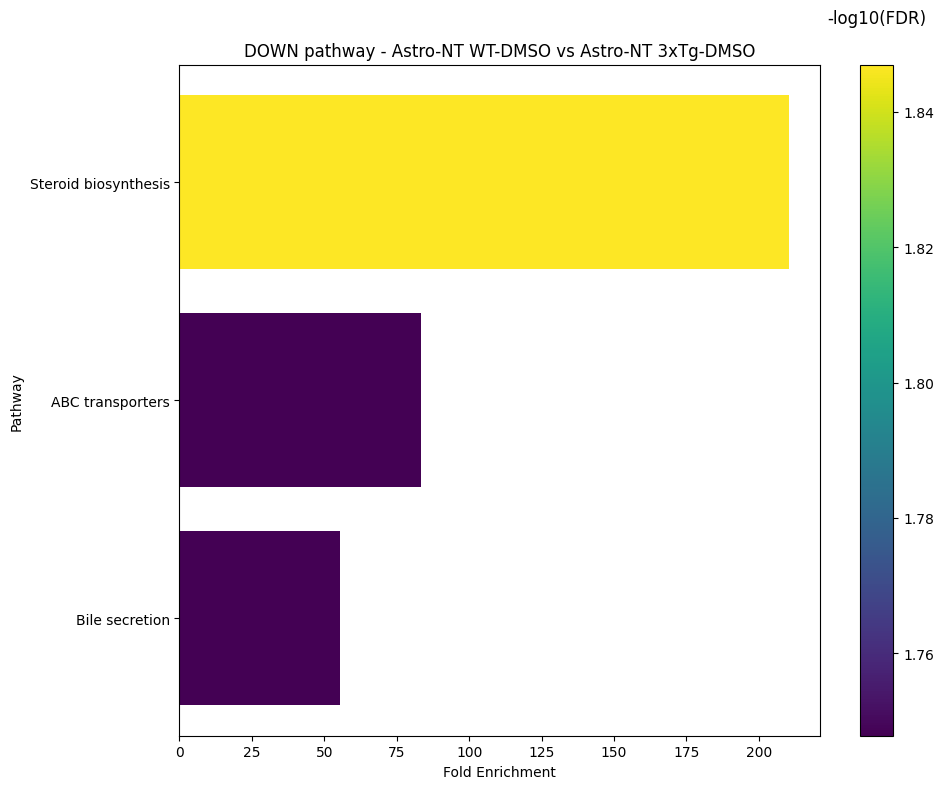

In [19]:
display_kegg_enrichment(DOWN_KEGG,
                        fig_title=f'DOWN pathway - {ctr_name} vs {cnd_name}',
                        save_path=f'figures/{ctr_name}_{cnd_name}_display_KEGG_enrichment_DOWN')